# 시계열 데이터분석 기본 모델
- SMA
- WMA
- SES
- ARIMA

## SMA
- **Simple Moving Average**
- rolling과 같은 의미

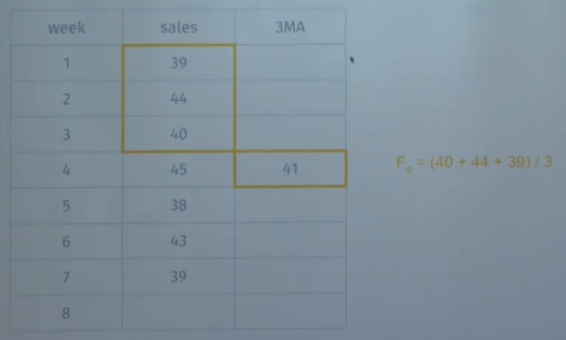

## WMA
- **Weighted Moving Average**
- SMA에서 weight를 부여한 moving average
- 가장 최근의 값에 큰 가중치를 부여

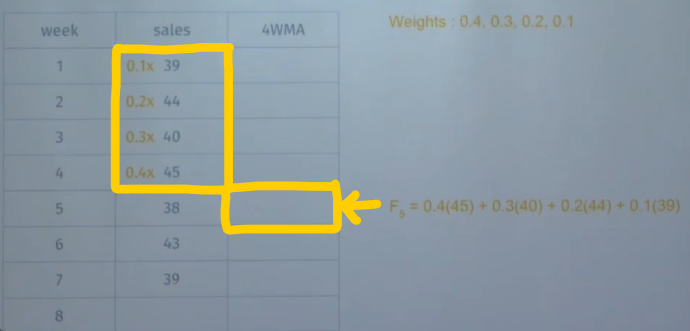

## SES
- **Simple Exponential Smoothing**
- 수식을 통해 이전값을 고려함

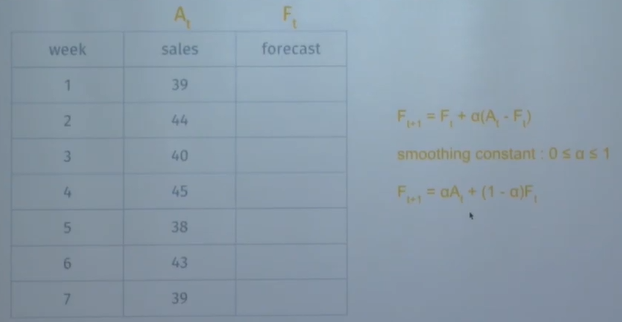

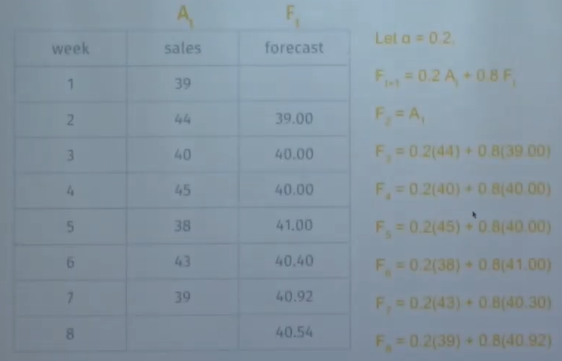

하지만 이런 모델들은 Trend나 Seasonality를 반영하지 못함!

그래서 새로 나오는 것들이 있기도 함

## 실습

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
airline = \
pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [26]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### SMA (Simple Moving Average)

In [5]:
airline['6M SMA']=airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12M SMA']=airline['Thousands of Passengers'].rolling(window=12).mean()

<AxesSubplot:xlabel='Month'>

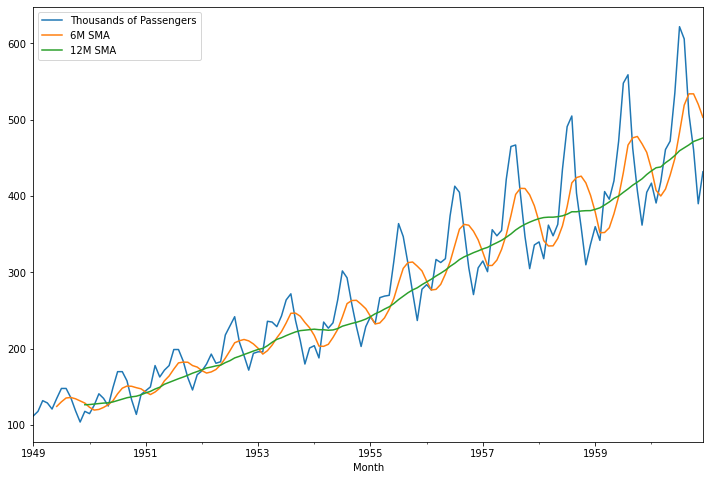

In [8]:
airline.plot(figsize=(12,8))

In [24]:
# 잔차 평균 구하기
from sklearn.metrics import mean_squared_error
mean_squared_error(airline['Thousands of Passengers'].iloc[5:], airline['6M SMA'].dropna())

2091.7370103916865

### WMA (Weighted Moving Average)

In [27]:
airline['WMA 6'] = airline['Thousands of Passengers'].ewm(span=12).mean()
airline['WMA 12'] = airline['Thousands of Passengers'].ewm(span=6).mean()

In [28]:
airline.head()

,Thousands of Passengers,WMA 6,WMA 12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,115.250000,115.500000
1949-03-01,132,121.787529,122.917431
1949-04-01,129,124.064224,125.266892
1949-05-01,121,123.231685,123.769332


<AxesSubplot:xlabel='Month'>

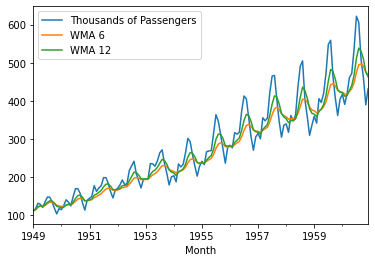

In [29]:
airline.plot()

SMA와는 다르게 밀리는 현상이 없고 잘 반영됨

### SES (Simple Exponential Smoothing), Holt's, Holt-Winter's
- SMA, WMA, SES 는 Trend나 Seasonality 반영 X
- Holt's 는 Trend 반영
- Holt-Winter는 Trend + Seasonality 반영 O

In [30]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [32]:
# 이는 모델링이기에 train test로 나누어줘야함
train = airline[:'1959']
test = airline['1960':]

<AxesSubplot:xlabel='Month'>

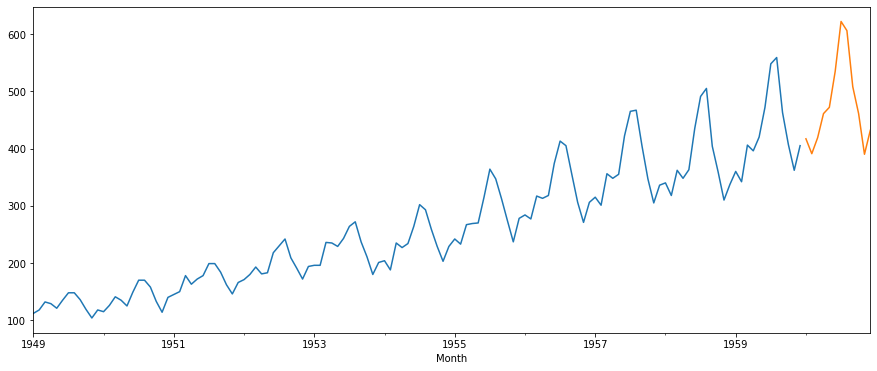

In [33]:
train['Thousands of Passengers'].plot(figsize=(15,6))
test['Thousands of Passengers'].plot(figsize=(15,6))

이런식으로 마지막의 test를 에측하는 모델링 진행

In [34]:
# 모델 생성
ses_model = SimpleExpSmoothing(np.asarray(train['Thousands of Passengers']))

C:\Users\bob8d\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [36]:
# 해당 train을 통해 모델 학습
ses_result = ses_model.fit()

In [38]:
# 원본 데이터
y_hat = test.copy()

In [39]:
# 모델의 예측 결과를 SES에 저장 (비교하기 위함)
y_hat['SES'] = ses_result.forecast(len(test)) # test의 길이 만큼 예측

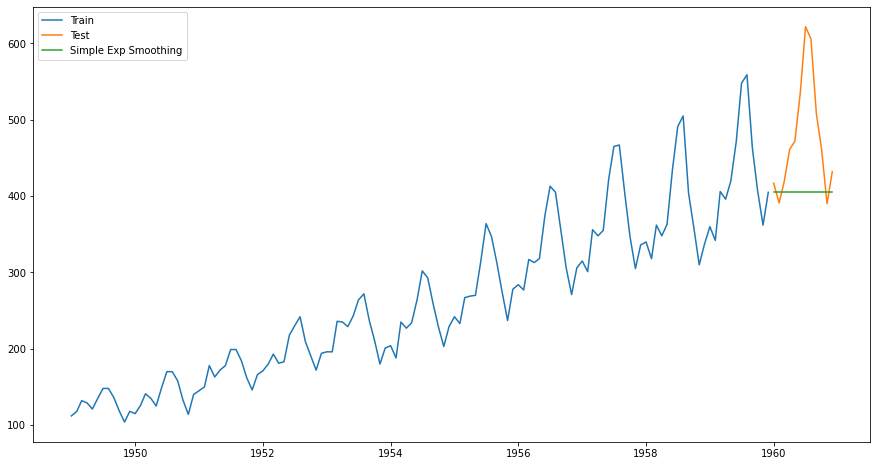

In [41]:
plt.figure(figsize=(15,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['SES'], label = 'Simple Exp Smoothing')
plt.legend()

보는 것과 같이 Trend와 Seasonality가 전혀 반영이 안됨

In [43]:
# 잔차 측정
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'], y_hat['SES']))
rmse

103.12445366139319

### Holt's

In [45]:
from statsmodels.tsa.api import Holt

In [46]:
holt_model = Holt(np.asarray(train['Thousands of Passengers']))

C:\Users\bob8d\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [47]:
holt_result = holt_model.fit()

In [48]:
y_hat['HOLT'] = holt_result.forecast(len(test))

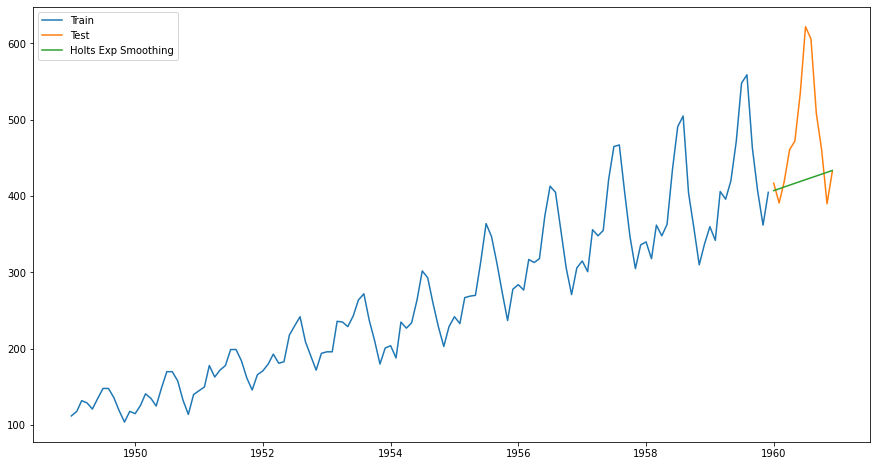

In [49]:
plt.figure(figsize=(15,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['HOLT'], label = 'Holts Exp Smoothing')
plt.legend()

보면 Trend는 반영이 되었지만 Seasonality는 반영하지 못함

In [51]:
# 잔차 측정
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'], y_hat['HOLT']))
rmse

92.10399279260226

### Holt-Winter's
- 이거 같은 경우 seasonality 주기를 미리 알려줘야됨

In [52]:
from statsmodels.tsa.api import ExponentialSmoothing

In [53]:
winter_model = ExponentialSmoothing(
    np.asarray(train['Thousands of Passengers']),
    seasonal_periods = 12, trend='add', seasonal='add'
)

C:\Users\bob8d\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [55]:
winter_result = winter_model.fit()

In [57]:
y_hat['WINTER'] = winter_result.forecast(len(test))

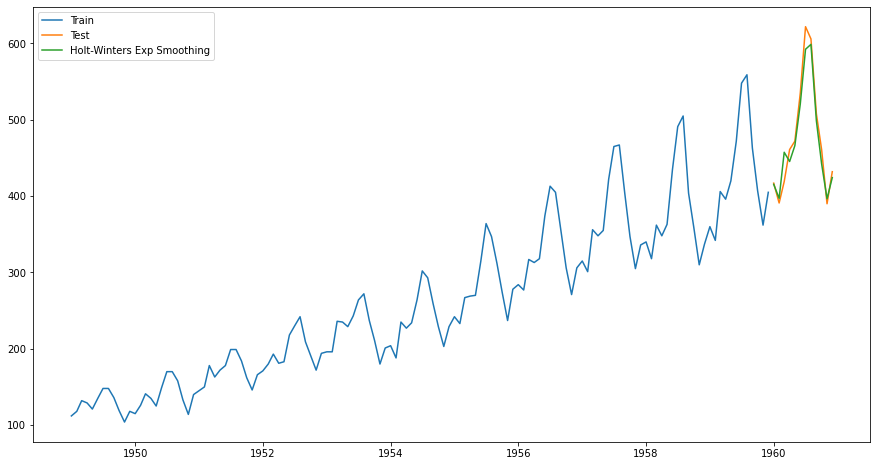

In [58]:
plt.figure(figsize=(15,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['WINTER'], label = 'Holt-Winters Exp Smoothing')
plt.legend()

In [59]:
# 잔차 측정
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'], y_hat['WINTER']))
rmse

16.98114161550258

Holt-Winter's 같은 경우 Trend와 Seasonality가 확실하다고 생각될 때 사용할 수 있음  
But, 이런 경우는 사실 드물지요 -> 그래서 ARIMA 모델이 나옴

### ARIMA
- Trend만 있다하면 파라미터는 3개
- Seasonality까지 있다하면 파라미터는 총 7개
- 이들의 최적의 조합을 찾아 예측하는 것
- ARIMA(p,d,q)(P,D,Q)m
    - trend 관련 : p,d,q
    - seasonality 관련 : P,D,Q,m

In [60]:
import statsmodels.api as sm

In [63]:
arima = sm.tsa.statespace.SARIMAX(train['Thousands of Passengers'],
                                 order=(2,1,1),
                                 seasonal_order=(0,1,0,12),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
# enforce 둘은 에러방지를 위해 False 값 설정

C:\Users\bob8d\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\bob8d\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [64]:
arima_result = arima.fit()

In [66]:
# forward를 통해서 예측할 수 있지만 여기선 predict도 사용 가능
# 원래 Arima 같은 경우 그 다음 하나만을 예측하지만, 연속된 데이터에 대한 예측을 위해 
# dynamic=True를 통해 예측된 값을 이용하여 또 예측하게 만들어줌
y_hat['ARIMA'] = \
arima_result.predict(start='1960-01-01', end='1960-12-01', dynamic=True)

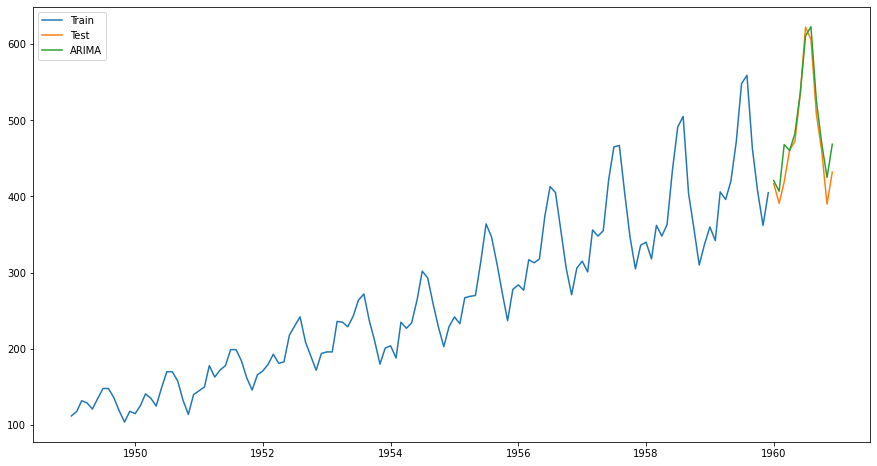

In [67]:
plt.figure(figsize=(15,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['ARIMA'], label = 'ARIMA')
plt.legend()

In [68]:
# 잔차 측정
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'], y_hat['ARIMA']))
rmse

22.650964249560218